## Imports all required packages for Data cleansing and modeling 

In [2]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier  as GBC
from xgboost.sklearn import XGBClassifier as XGB
from apyori import apriori as ap
import matplotlib.pyplot as plt
from datetime import datetime
import time
import json
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings("ignore")

## Data Import and Cleansing 
### 1) Imports data from json to csv converter and renames columns for convienience
### 2) Retitles page visits that show the workout for a particular day to "Workout for THAT Day". This is done for congruency across the data to indicate when a user intended to visit a page designated for the workout of the day
  

In [3]:
cfdc_new = pd.read_csv('C:/Users/nathan.ellis/Documents/Python Scripts/results.csv')

new_columns = ['user','date', 'goal', 'revenue', 'session_count', 'session_duration', 'device',
               'channel', 'page_viewed', 'time', 'type', 'page_title', 'page_url', 'title']

cfdc_new.columns = new_columns

cfdc_new.date = pd.to_datetime(cfdc_new.date)

cfdc = cfdc_new.copy()

In [4]:
title_list = list(cfdc.page_title)

c = []

for i in range(0, len(title_list), 1):
    a = title_list[i]
    monday = a.find('Monday')
    tuesday = a.find('Tuesday')
    wednesday = a.find('Wednesday')
    thursday = a.find('Thursday')
    friday = a.find('Friday')
    saturday = a.find('Saturday')
    sunday = a.find('Sunday')
    
    if (sunday >=0) | (monday >=0)| (tuesday >=0)| (wednesday >=0)| (thursday >=0)| (friday >=0)| (saturday >=0):  
        b = title_list[i] 
        b = b.replace(a, 'Workout for THAT Day')
        c.append(b)
    else:
        c.append(a)
cfdc['page_title'] = c

### New session count 

#### 1) Function creates and enumerates each session that the user genreates while on CFDC website

In [5]:

### I had to use this instead of np.where because of labeling the unique sessions

cfdc['new_session'] = 0
a = 0
for i in range(0, len(cfdc)+1):
    if (cfdc.page_viewed[i:i+1].values > 0):
        a = a+1
        cfdc['new_session'][i:i+1]= a
    else: 
        cfdc['new_session'][i:i+1] = np.nan


### Backfills missing data values 
#### 1) Needed to backfill values that were missing in order to correctly sort data into user visit groupings

In [6]:
cfdc = cfdc.drop(['title', 'type', 'goal', 'revenue'],axis =1)

cfdc = cfdc.fillna(method = 'ffill')

cfdc.date = cfdc.date.fillna(method = 'ffill')

cfdc = cfdc.drop_duplicates(subset = None, keep = 'first', inplace = False)

cfdc = cfdc.reset_index()

### Creates time split function and time labels 

#### 1) Creates time splitting functions for the time the user visited a webpage and the duration of time the user stayed on the webpage. This was done to create the proper format for model utilization

In [49]:
def timesplit(time):

    c = time.split()

    d = list(c[0])
    
    e = list(c[1])

    d.remove(':')

    if len(d) > 3:
        final = int(d[0]+d[1])
        
    elif len(d) <= 3:
        final = int(d[0])
        
    if e[0] == 'P':
        final = final + 12
    else:
        final = final 
    
    return(final)


In [53]:
def timesplit_duration(time):

    c = time.split()

    d = list(c[0])
    
    d.remove(':')

    if len(d) > 3:
        final = int(d[0]+d[1])
        
    elif len(d) <= 3:
        final = int(d[0])
        
    
    return(final)


In [54]:
final_time = []

for i in range(0, len(cfdc)):
    final = timesplit_duration(cfdc.session_duration[i])
    
    final_time.append(final)
    
cfdc['duration_labels'] = final_time


In [52]:
final_time = []

for i in range(0, len(cfdc)):
    final = timesplit(cfdc.time[i])
    
    final_time.append(final)
    
cfdc['time_labels'] = final_time


### Filters out for only visits in which the user hit more than one page

#### 1) Because basic Google Analytics can provide the descriptive analytics behind what pages we hit only one time, the focus was scoped to only provide predictions AFTER the user had landed on the initial page. Therefore, the pages viewed needed to be > 2 per session

In [60]:
cfdc = cfdc[cfdc.page_viewed > 2]

### Reverses the dataframe and adds sequence count

#### 1) Arranges the pages visited in ascending order

In [61]:
cfdc['sequence'] = cfdc.iloc[::-1].groupby('new_session')['new_session'].cumcount()+1
    


### Creates unique category labels for features

#### 1) The models need to utilize unique label identifiers to find correlations within the data. Therefore, category labels are utilized. 

In [56]:
cfdc['page_title'] = cfdc['page_title'].astype('category')

cfdc['page_title_labels'] = cfdc['page_title'].cat.codes


cfdc['channel'] = cfdc['channel'].astype('category')

cfdc['channel_labels'] = cfdc['channel'].cat.codes


cfdc['device'] = cfdc['device'].astype('category')

cfdc['device_labels'] = cfdc['device'].cat.codes

### Features and Discrete 

#### 1) The main features utilized in prediciting the user experience.

In [63]:
features = ['sequence', 'channel_labels', 'time_labels', 'device_labels', 'duration_labels']

discrete = ['page_title_labels']

In [66]:
session_list = list(cfdc.new_session.unique())

session_list = session_list

acc_list_xg = []
acc_list_rf = []
acc_list_gb = []
acc_list_combo = []

n_estimators = 100

for i in session_list:
    
    train = cfdc[cfdc.new_session != i]
    test = cfdc[cfdc.new_session == i]
    
    X_train = train[features]
    y_train = train[discrete].values.ravel()

    X_test = test[features]
    y_test = test[discrete].values.ravel()
    
    RF = RFC(n_estimators = n_estimators)
    GB = GBC(n_estimators = n_estimators)
    XG = XGB(n_estimators = n_estimators)

    RF.fit(X_train, y_train)
    GB.fit(X_train, y_train)
    XG.fit(X_train, y_train)

    rf_pred = RF.predict(X_test)
    gb_pred = GB.predict(X_test)
    xg_pred = XG.predict(X_test)

    accuracy_rf = RF.score(X_test, y_test)
    accuracy_gb = GB.score(X_test, y_test)
    accuracy_xg = XG.score(X_test, y_test)
    
    ##if len(y_test) < 3:
      #  acc_list.append(accuracy_rf)
   # else:
    acc_list_xg.append(accuracy_xg)
    acc_list_rf.append(accuracy_rf)
    acc_list_gb.append(accuracy_gb)
     

print('Overall KyleBoost:', sum(acc_list_xg)/len(acc_list_xg))
print('Overall Random Forest:', sum(acc_list_rf)/len(acc_list_rf))
print('Overall Gradient Boost:', sum(acc_list_gb)/len(acc_list_gb)) 

    

Overall KyleBoost: 0.538862433862434
Overall Random Forest: 0.45061507936507955
Overall Gradient Boost: 0.48780423280423285


### Model Value Counts

  #### 1) This counts the accuracies of the model against the test data. Again, the overall goal was to achieve a higher number of 100% accuracies than any other accuracy. This means that the model was 100% accurate in predicting not only the pages hit within the website but also the order that they were hit.
  
  #### 2) As we can see, the model had a 100% accuracy count of 50. The amount that the model was >75% accurate in predicting was approximately 32% of the time. 

In [68]:
rf = pd.DataFrame(acc_list_xg)
                  
rf.columns = ['avg']

rf.avg.value_counts()

1.000000    50
0.500000    39
0.000000    30
0.333333    20
0.666667    18
0.250000     9
0.750000     5
0.200000     4
0.600000     2
0.400000     1
0.285714     1
0.142857     1
Name: avg, dtype: int64

### Feature Importances

#### 1) By examining the features, the feature that had the greatest impact in determing the sequenced outcome is found.
#### 2) In this case for the most accurate model (KyleBoost), the channel labels was the features that had the greatest impact in reducing Gini. 

                Importance %
Features                    
channel_labels      0.323589
sequence            0.214534
duration_labels     0.181807
device_labels       0.170551
time_labels         0.109519


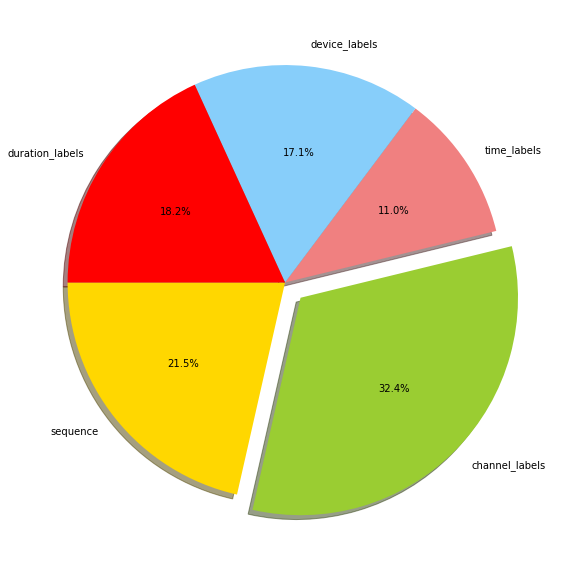

In [69]:
plt.figure(figsize = (15, 10))

feature_imp = (XG.feature_importances_)

importances = pd.DataFrame([features,feature_imp])

final = importances.transpose()

final.columns = ['Features', 'Importance %']

final = final.sort_values(by = 'Importance %', ascending = False)

final = final.set_index('Features')

print(final)

#a = final['Importance %'].plot(kind = 'pie', color = 'r', alpha = .5,figsize=(20,10))

labels = features
sizes = feature_imp
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red']
explode = (0, 0.1, 0, 0, 0) 

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=180)

plt.show()


## Setting up for Apyori Algorithm analyses

In [219]:
df_final = pd.DataFrame()

for session in np.unique(cfdc.new_session):
    
    a = session

    b = list(cfdc.page_title[cfdc.new_session == session])
    
    b.reverse()
    
    b.append('exit')
    
    dictionary = {a:b}

    df_1 = pd.DataFrame(dictionary)

    df_2 = df_1.transpose()

    df_final = pd.concat([df_final, df_2])
    


In [220]:
records = []

for i in range(0, len(df_final)):
    record = (([str(df_final.values[i,j]) for j in range(0, len(df_final.columns))]))
    
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)
    for ele in record:
        if (ele == 'nan'):
            record.remove(ele)

    records.append(record)
    #records.remove('exit'), 'exit'

In [70]:
association_rules = ap(records, min_support = .0005, min_confidence = 1/(len(cfdc)), min_lift = .5, min_length = 2)

In [71]:
association_results = list(association_rules)
print(len(association_results))

275


In [72]:
final = pd.DataFrame()

for i in range(0, (len(association_results))):
    
    a = association_results[i]
    
    if len(a[0]) > 0:
        b = (pd.DataFrame(a[2]))
        final = pd.concat([final, b])
    

In [73]:
for item in association_results:
    pair = item[0]
    items = [x for x in pair]
   
    if (len(pair) > 1) & (len(pair) <= 2): 
        
        print('Rule: ' + str(items[0] + '-> '+ items[1] ) )

        print('Support: ' + str(item[1]))

        print('Confidence: ' + str(item[2][0][2]))
        print('Lift: ' + str(item[2][0][3]))

        print('Number of Occurrences: ' + str(item[1] * len(records)))
        
        print('=============================')
        
        
        
    elif (len(pair) > 2) & (len(pair) <= 4): 
        
        print('Rule: '+ items[2]   + '-> '+ items[1]  + '-> '+ str(items[0]))

        print('Support: ' + str(item[1]))

        print('Confidence: ' + str(item[2][0][2]))
        print('Lift: ' + str(item[2][0][3]))
        
        print('Number of Occurrences: ' + str(item[2] * len(records)))
        print('=============================')
        
      
    elif (len(pair) > 3) & (len(pair) <= 5 & (item[0] != 'exit')): 
        
        print('Rule: '+ items[0] + '-> '+ items[1] + '-> '+ items[2] + '-> '+ items[3]  + '-> '+ items[4] )

        print('Support: ' + str(item[1]))

        print('Confidence: ' + str(item[2][0][2]))
        print('Lift: ' + str(item[2][0][3]))
        
        #print('Number of Occurrences: ' + str(item[0] * len(records)))

        print('=============================')

      

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

